# Fake news tweet analysis on FakeNewsNet dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

from utils import collect_tweets, collect_news

%matplotlib inline


[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jakob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
root_dir = "/media/jakob/DATA/Projects/FakeNewsNet/code/fakenewsnet_dataset/"

datasets = [
    "politifact",
    "gossipcop"
]

random_seed = 42    # For TSNE

In [3]:
politifact_news = pd.read_json(collect_news(root_dir + datasets[0]))
politifact_news.head(5)

,url,text,images,top_img,keywords,authors,canonical_link,title,meta_data,movies,publish_date,source,summary,truth
0,http://www.senate.gov/legislative/LIS/roll_cal...,Roll Call Vote 111th Congress - 1st Session\n\...,[http://www.senate.gov/resources/images/usFlag...,http://www.senate.gov/resources/images/us_sen.ico,[],[],,U.S. Senate: U.S. Senate Roll Call Votes 111th...,"{'viewport': 'width=device-width, initial-scal...",[],NaN,http://www.senate.gov,,real
1,http://www.politico.com/news/stories/0509/2241...,Barack Obama ended up in the middle of an unli...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://s3-origin-images.politico.com/news/0905...,[],[Alexander Burns],https://www.politico.com/story/2009/05/trump-o...,Trump on Prejean: Same as Obama,"{'article': {'opinion': 'false'}, 'og': {'titl...",[],1.242120e+09,http://www.politico.com,,real
2,http://pollingreport.com/CongJob.htm,Follow @pollreport CONGRESS – Job Rating See a...,[http://pollingreport.com/images/logo3.gif],,[],[],,Congress: Job Ratings,"{'GENERATOR': 'Microsoft FrontPage 5.0', 'Micr...",[],NaN,http://pollingreport.com,,real
3,https://web.archive.org/web/20090514023215/htt...,House GOP Introduces Keep Terrorists Out of Am...,[https://web.archive.org/web/20090514023215im_...,https://web.archive.org/web/20090514023215im_/...,[],[],,House GOP Introduces Keep Terrorists Out of Am...,{},[],NaN,https://web.archive.org,,real
4,https://web.archive.org/web/20061116002411/htt...,'); //--> E-mail | Print | Comments | Request ...,[https://web.archive.org/web/20061116002411im_...,https://web.archive.org/web/20061116002411im_/...,[],[Robert Lenzner],,Is The End In Sight For Supermax?,{'description': 'Americas most secure and most...,[],1.145052e+09,https://web.archive.org,,real


In [4]:
text_data = politifact_news[["text", "title", "truth"]]
text_data

,text,title,truth
0,Roll Call Vote 111th Congress - 1st Session\n\...,U.S. Senate: U.S. Senate Roll Call Votes 111th...,real
1,Barack Obama ended up in the middle of an unli...,Trump on Prejean: Same as Obama,real
2,Follow @pollreport CONGRESS – Job Rating See a...,Congress: Job Ratings,real
3,House GOP Introduces Keep Terrorists Out of Am...,House GOP Introduces Keep Terrorists Out of Am...,real
4,'); //--> E-mail | Print | Comments | Request ...,Is The End In Sight For Supermax?,real
...,...,...,...
921,10:30 pm last night police received a call abo...,Manager killed 10 employees at checkers on 183...,fake
922,"WASHINGTON, D.C. (AP) — At a press conference ...",Paul Ryan: “Donald Trump Plans To Resign From ...,fake
923,For full functionality of this site it is nece...,,fake
924,"As we promised, Freedom Crossroads has just le...",BREAKING: The Democrat James Comey Has Been Ha...,fake


In [5]:
punctuation =  set('!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@')
stopwords = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

text_data = text_data.apply(lambda x: x.astype(str).str.lower())
text_data[["text", "title"]] = text_data[["text", "title"]].applymap(word_tokenize)
text_data[["text", "title"]] = text_data[["text", "title"]].applymap(set)
text_data[["text", "title"]] = text_data[["text", "title"]].applymap(lambda x: x - stopwords)
text_data[["text", "title"]] = text_data[[
    "text", "title"]].applymap(lambda x: x - punctuation)
    
text_data

,text,title,truth
0,"{d-ne, enzi, april, cornyn, purpose, kaufman, ...","{senate, votes, 111th, u.s., call, roll, congr...",real
1,"{“, answer, addressing, believe, honorable, mo...","{obama, trump, prejean}",real
2,"{1/13-16/11, 3/9-12/06, 6/3/12, 1/11-14/07, 1/...","{job, ratings, congress}",real
3,"{destroying, bringing, “, opposes, 2009., unle...","{keep, america, terrorists, act, house, introd...",real
4,"{1994, justice, purpose, 23, 4.9, wider, ameni...","{sight, supermax, end}",real
...,...,...,...
921,"{supplies, money, 10, night, gardens.manager, ...","{10, checkers, manager, 27ave, 183st, employee...",fake
922,"{criticism, grounds, charity, “, believe, hotl...","{within, “, next, ryan, days, donald, resign, ...",fake
923,"{site, enable, full, web, functionality, brows...",{},fake
924,"{“, debbie, none, clock, talk, working, chair,...","{revealed, james, details, democrat, comey, af...",fake


In [6]:
text_data[["text", "title"]] = text_data[["text", "title"]].applymap(
    lambda x: list(map(lambda token: p_stemmer.stem(token), x)))
text_data[["text", "title"]] = text_data[["text", "title"]].applymap(
    lambda x: list(map(lambda token: wordnet_lemmatizer.lemmatize(token), x)))

text_data

,text,title,truth
0,"[d-ne, enzi, april, cornyn, purpos, kaufman, k...","[senat, vote, 111th, u.s., call, roll, congress]",real
1,"[“, answer, address, believ, honor, morn, pere...","[obama, trump, prejean]",real
2,"[1/13-16/11, 3/9-12/06, 6/3/12, 1/11-14/07, 1/...","[job, rate, congress]",real
3,"[destroy, bring, “, oppos, 2009., unless, judg...","[keep, america, terrorist, act, hous, introduc...",real
4,"[1994, justic, purpos, 23, 4.9, wider, amen, c...","[sight, supermax, end]",real
...,...,...,...
921,"[suppli, money, 10, night, gardens.manag, rece...","[10, checker, manag, 27ave, 183st, employe, kill]",fake
922,"[critic, ground, chariti, “, believ, hotlin, a...","[within, “, next, ryan, day, donald, resign, o...",fake
923,"[site, enabl, full, web, function, browser, in...",[],fake
924,"[“, debbi, none, clock, talk, work, chair, mat...","[reveal, jame, detail, democrat, comey, affair...",fake


In [7]:
vectorizer = CountVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    stop_words=None,
    tokenizer=lambda x: text_data["text"][int(x)]
)

text_td_matrix = vectorizer.fit_transform([str(i) for i in range(len(text_data["text"]))])

First, we load the tweets from our dataset to a Pandas DataFrame object for easier usage. We use a helper function ``collect_tweets`` that also adds a ``truth`` value to the tweet, depending on what kind of news it is talking about. Let's see how the tweets look like. 

In [8]:
text_td_matrix

<926x29652 sparse matrix of type '<class 'numpy.int64'>'
	with 224049 stored elements in Compressed Sparse Row format>

In [9]:
pca = TruncatedSVD(n_components=2)
projection = pca.fit_transform(text_td_matrix)
projection.shape


(926, 2)

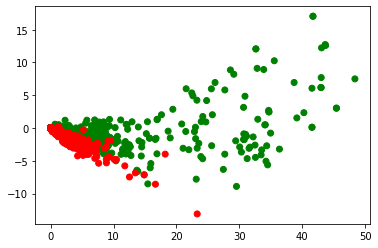

In [10]:
colors = ["green" if truth == "real" else "red" for truth in text_data["truth"]]
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [11]:
politifact_tweets = pd.read_json(collect_tweets(root_dir + datasets[0]))
politifact_tweets.head(1)

AttributeError: module 'os' has no attribute 'list'

We can see that the most important attributes of a tweet are ``text`` and ``user``. The ``place`` attribute is also very interesting, but is unfortunately not present in all tweets. Now, let's take a closer look at the ``user`` objects.

In [ ]:
politifact_tweets["user"].head(1)


There are a number of interesting fields in the user object:
- ``verified`` (tells us whether the account is verified or not)
- ``followers_count``
- ``friends_count``
- ``favourites_count`` (the number of tweets the user has liked in their lifetime)
- ``statuses_count`` (the number of tweets and retweets the user has issued in their lifetime)

The above fields all have integer or boolean values, which makes them easy to work with in the context of data analysis. We will use these fields to try to visualize the users that tweeted real or fake news. Because we have 5 features, we will need some kind of dimensionality reduction to visualize them in 2D. 

In [ ]:
features = ["verified", "followers_count", "friends_count", "favourites_count", "statuses_count"]

politifact_tweets.drop(politifact_tweets.columns.difference(["user", "truth"]), 1, inplace=True)


